In [1]:
import numpy as np
MY_DEPTH = 10
from scipy.optimize import minimize_scalar
import re
def lp_minimizer(x, p):
    """
    Find the Lp minimizer for the given 1D vector x and a specified value of p.
    
    Parameters:
    - x: 1D numpy array (row or column vector)
    - p: Lp norm value (p >= 1)
    
    Returns:
    - m_p: The minimizer of the Lp norm.
    """
    # Objective function: sum of |x_i - m|^p for each element in the vector
    def objective(m):
        return np.sum(np.abs(x - m) ** p)
    
    # Use minimize_scalar to find the value of m that minimizes the objective function
    result = minimize_scalar(objective, method='bounded', bounds=(np.min(x), np.max(x)))
    
    # The minimizer
    m_p = result.x
    minimal_value = result.fun
    return m_p, minimal_value

class DecisionTreeRegressor:
    def __init__(self, min_samples_split=2, max_depth=float('inf'), error_method='variance', cyclic_padding=0, loss_norm=2):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth if isinstance(max_depth, int) else float('inf')  # Ensure max_depth is an int or inf
        self.root = None
        self.cyclic_padding = cyclic_padding
        self.loss_norm = loss_norm

        # Validate and set the error_method parameter
        if isinstance(error_method, list):
            if len(error_method) != max_depth:
                raise ValueError("The error_method list must be the same length as max_depth.")
            if not all(method in ['variance', 'minimax', 'cyclic_minimax', 'weighted_variance','xminimizer'] for method in error_method):
                raise ValueError("Error_method list can only contain 'variance', 'minimax', 'xminimizer', or 'cyclic_minimax'.")
            self.error_method = error_method
        elif error_method in ['variance', 'minimax', 'cyclic_minimax', 'weighted_variance','xminimizer']:
            self.error_method = [error_method] * int(max_depth)  # Expand to full depth if max_depth is specified
        else:
            raise ValueError("Invalid error_method. It must be either 'variance', 'minimax', 'cyclic_minimax', 'weighted_variance', 'xminimizer' or a list of these.")

    class Node:
        def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None, data=None, targets=None, is_leaf=None):
            self.feature_index = feature_index
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value
            self.data = data
            self.targets = targets
            #if is_leaf is not None:
            #    self.is_leaf = is_leaf
            if self.left == None and self.right == None:
                self.is_leaf = True
            else:
                self.is_leaf = False

    def fit(self, X, y, depth=0):
        if len(X) < self.min_samples_split or depth >= self.max_depth:
            node = self.Node(value=y.mean(), data=X, targets=y)
            node.is_leaf = True
            return node

        current_error_method = self.error_method[depth]
        if current_error_method == 'cyclic_minimax':
            best_feature, best_threshold = self.cyclic_minimax_split(X, y, depth)
        else:
            best_feature, best_threshold = self.find_best_split(X, y, current_error_method)

        if best_feature is None or best_threshold is None:
            node = self.Node(value=y.mean(), data=X, targets=y)
            node.is_leaf = True
            return node

        left_indices = X[:, best_feature] <= best_threshold
        right_indices = ~left_indices
        left_subtree = self.fit(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self.fit(X[right_indices], y[right_indices], depth + 1)
        return self.Node(feature_index=best_feature, threshold=best_threshold, left=left_subtree, right=right_subtree, data=X, targets=y)

    def find_best_split(self, X, y, error_method):
        num_features = X.shape[1]
        min_error = float('inf')
        best_feature = None
        best_threshold = None
        if error_method == 'xminimizer':
            for feature_index in range(num_features):
                Xcoord = X[:,feature_index].ravel()
                index = feature_index
                threshold, error = lp_minimizer(Xcoord, self.loss_norm)
                #print(index)
                if error < min_error:
                    min_error = error
                    best_feature = feature_index
                    best_threshold = threshold
            #print(min_error,best_feature,best_threshold,'?')
        else:
            for feature_index in range(num_features):
                index, threshold, error = self.evaluate_splits(X, y, feature_index, error_method)
                if error < min_error:
                    min_error = error
                    best_feature = feature_index
                    best_threshold = threshold

        return best_feature, best_threshold

    def cyclic_minimax_split(self, X, y, depth):
        num_features = X.shape[1]
        feature_index = (self.cyclic_padding + depth) % num_features
        _, best_threshold, _ = self.evaluate_splits(X, y, feature_index, 'minimax')
        return feature_index, best_threshold

    def evaluate_splits(self, X, y, feature_index, error_method):
        thresholds = np.unique(X[:, feature_index])
        min_error = float('inf')
        best_threshold = None

        for threshold in thresholds:
            left_indices = X[:, feature_index] <= threshold
            right_indices = ~left_indices
            error = self.calculate_error(y, left_indices, right_indices, error_method) 
            if error < min_error:
                min_error = error
                best_threshold = threshold
        return feature_index, best_threshold, min_error 

    def calculate_p_norm_error(self, y, indices, p):
        if p == np.inf:
            # Max norm (L-infinity) handling
            return np.max(np.abs(y[indices] - np.mean(y[indices])))
        else:
            # General p-norm
            return np.sum(np.abs(y[indices] - np.mean(y[indices])) ** p)
    def calculate_error(self, y, left_indices, right_indices, error_method):
        if sum(left_indices)<=1 or sum(left_indices) is None:
            return np.inf
        if sum(right_indices)<=1 or sum(right_indices) is None:
            return np.inf 
        left_error = right_error = 0
        if error_method == 'variance':
            if self.loss_norm == 2:
                # Special case for standard variance (quadratic norm)
                left_error = ((y[left_indices] - y[left_indices].mean()) ** 2).sum()
                right_error = ((y[right_indices] - y[right_indices].mean()) ** 2).sum()
            else:
                # Generic p-norm
                left_error = self.calculate_p_norm_error(y, left_indices, self.loss_norm)
                right_error = self.calculate_p_norm_error(y, right_indices, self.loss_norm)
            return left_error+right_error
        elif error_method == 'minimax' or error_method == 'cyclic_minimax':
            if self.loss_norm == 2:
                # Special case for standard variance (quadratic norm)
                left_error = ((y[left_indices] - y[left_indices].mean()) ** 2).sum()
                right_error = ((y[right_indices] - y[right_indices].mean()) ** 2).sum()
            else:
                # Generic p-norm
                left_error = self.calculate_p_norm_error(y, left_indices, self.loss_norm)
                right_error = self.calculate_p_norm_error(y, right_indices, self.loss_norm)
            return max(left_error, right_error)
        elif error_method == 'weighted_variance':
            left_error = sum(left_indices) * ((y[left_indices] - y[left_indices].mean()) ** 2).sum()
            right_error = sum(right_indices) * ((y[right_indices] - y[right_indices].mean()) ** 2).sum()
            return left_error+right_error

        return left_error + right_error

    def predict(self, X):
        predictions = [self._predict_one(x, self.root) for x in X]
        return predictions

    def _predict_one(self, x, node):
        while not node.is_leaf:
            if x[node.feature_index] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.value
    
    def prune(self, node=None):
        if node is None:
            node = self.root

        if node.is_leaf:
            return

        if node.left.is_leaf and node.right.is_leaf:
            original_error = self.node_error(node)
            node.is_leaf = True
            node.value = node.targets.mean()
            pruned_error = self.node_error(node)
            complexity_alpha = 0.1
            original_complexity = original_error + complexity_alpha*self.count_leaves()
            pruned_complexity = pruned_error + complexity_alpha*self.count_leaves()
            if pruned_complexity > original_complexity:
                node.is_leaf = False
                node.value = None
            else:
                node.left = None
                node.right = None

        if not node.is_leaf:
            self.prune(node.left)
            self.prune(node.right)

    def node_error(self, node):
        if node.is_leaf:
            return ((node.targets - node.value) ** 2).mean()
        return ((self.predict(node.data) - node.targets) ** 2).mean()
    
    def print_tree(self, node=None, depth=0):
        if node is None:
            node = self.root
        if node.is_leaf:
            print(f"{'    ' * depth}Leaf: Predict = {node.value:.4f}")
        else:
            print(f"{'    ' * depth}Node: X[{node.feature_index}] <= {node.threshold:.4f}, "
                  f"Error = {self.node_error(node):.4f}")
            self.print_tree(node.left, depth + 1)
            self.print_tree(node.right, depth + 1)

    def node_error(self, node):
        if node.is_leaf:
            return ((node.targets - node.value) ** 2).mean()
        return ((self.predict(node.data) - node.targets) ** 2).mean()

    def count_leaves(self, node=None):
        if node is None:
            node = self.root
        if node.is_leaf:
            return 1
        else:
            return self.count_leaves(node.left) + self.count_leaves(node.right)
 

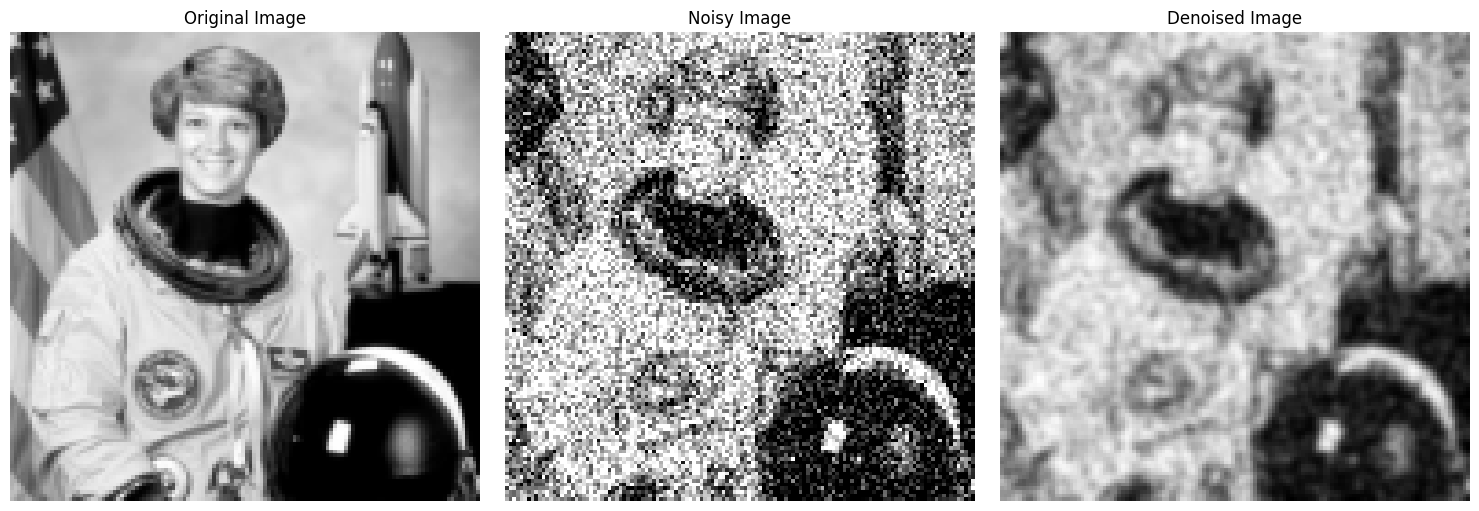

10


/tmp/ipykernel_2569631/2848107388.py:66: RuntimeWarning: Mean of empty slice.
  node = self.Node(value=y.mean(), data=X, targets=y)
/home/hrluo/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [2]:

""" # Create some sample data
np.random.seed(1)
X = np.linspace(-2, 2, 100).reshape(-1, 1)
X_new = np.linspace(-3, 3, 1000).reshape(-1, 1)
shared_noise_var = 0.1

def f_truth(X,noise_var=0.01):
    return  np.sin(X.ravel()*2) + np.random.randn(X.ravel().shape[0]) * noise_var

y = f_truth(X,shared_noise_var)
y_new = f_truth(X_new,shared_noise_var)

# Instantiate and train the decision tree
tree = DecisionTreeRegressor(min_samples_split=2, max_depth=3,error_method='variance')
tree.root = tree.fit(X, y)
tree.print_tree()
num_leaves = tree.count_leaves()
print(f"The number of leaves in the tree: {num_leaves}")
print('-'*100)
#tree.prune()
#tree.print_tree()
#num_leaves = tree.count_leaves()
#print(f"The number of leaves in the tree: {num_leaves}")

# Make predictions
predictions = tree.predict(X_new)

# Plotting the results
import matplotlib.pyplot as plt """
""" plt.scatter(X, y, color='blue', label='Data')
plt.plot(X_new, predictions, color='red', label='Decision Tree Predictions')
plt.xlabel('Feature X')
plt.ylabel('Target y')
plt.title('Decision Tree Regression Example, MSE='+str(np.mean((predictions-y_new)**2) ))
plt.legend()
plt.show() """



import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Setting seed for reproducibility
np.random.seed(1)
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import io, color, transform

def load_image(filepath, height=64, width=64):
    # Load the image
    image = io.imread(filepath)[:,:,0]
    
    # Convert to grayscale if it's a color image
    if len(image.shape) == 3:
        image = color.rgb2gray(image)
    
    # Resize the image if height and width are provided
    if height is not None and width is not None:
        image = transform.resize(image, (height, width), anti_aliasing=True)
    
    # Normalize the image
    image = (image - image.min()) / (image.max() - image.min())
    
    return image

# Add Gaussian noise to the image
def add_noise(image, mean=0, std=1.):
    noise = np.random.normal(mean, std, image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, 0, 1)  # Clip values to [0, 1] range

# Denoise the image using Gaussian filter
def denoise_image(noisy_image, sigma=1):
    denoised_image = ndimage.gaussian_filter(noisy_image, sigma=sigma)
    return denoised_image

 

# Load original image
original_image = load_image('astronaut.jpeg',128,128)

# Add noise
noisy_image = add_noise(original_image,0.,.25)

# Denoise the image
denoised_image = denoise_image(noisy_image)

# Plot the results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(noisy_image, cmap='gray')
axes[1].set_title('Noisy Image')
axes[1].axis('off')

axes[2].imshow(denoised_image, cmap='gray')
axes[2].set_title('Denoised Image')
axes[2].axis('off')

plt.tight_layout()
plt.show() 

#Better visualization
original_image = np.rot90(original_image, k=-1) 
noisy_image  = np.rot90(noisy_image, k=-1) 
height, width = original_image.shape
# Generating a 2D grid of features
x1 = np.linspace(0, 1, height)
x2 = np.linspace(0, 1, width)
X1, X2 = np.meshgrid(x1, x2)
X = np.c_[X1.ravel(), X2.ravel()]  # Create a 2-column matrix of features

 

y = noisy_image.flatten(order='F')

vari1=[]
wvari1=[]
mini1=[]
cyclic1=[]
vari2=[]
wvari2=[]
mini2=[]
cyclic2=[]

logvari=[]
logmini=[]
for depth in [MY_DEPTH]:
    print(depth)
    # Prepare the mesh grid for predictions and visualization
    X_new = np.c_[X1.ravel(), X2.ravel()]
    y_new = original_image.flatten(order='F')  # Slightly less noise for cleaner function visualization
    # Assuming the DecisionTreeRegressor class has already been imported and is available
    tree1 = DecisionTreeRegressor(min_samples_split=2, max_depth=depth, error_method='variance',loss_norm=1)
    tree1.root = tree1.fit(X, y)
    # Make predictions on the grid
    predictions1 = tree1.predict(X_new)
    predictions1 = np.asarray(predictions1).reshape(X1.shape)  # Reshape to 2D grid
    logvari.append(np.log(np.mean((predictions1.ravel()-y_new)**2)))
    vari1.append(np.mean((predictions1.ravel()-y_new)**2))

    tree1b = DecisionTreeRegressor(min_samples_split=2, max_depth=depth, error_method='weighted_variance',loss_norm=1)
    tree1b.root = tree1b.fit(X, y)
    # Make predictions on the grid
    predictions1b = tree1b.predict(X_new)
    predictions1b = np.asarray(predictions1b).reshape(X1.shape)  # Reshape to 2D grid
    wvari1.append(np.mean((predictions1b.ravel()-y_new)**2))

    tree2 = DecisionTreeRegressor(min_samples_split=2, max_depth=depth, error_method='minimax',loss_norm=1)
    tree2.root = tree2.fit(X, y)
    # Make predictions on the grid
    predictions2 = tree2.predict(X_new)
    predictions2 = np.asarray(predictions2).reshape(X1.shape)  # Reshape to 2D grid
    mini1.append(np.mean((predictions2.ravel()-y_new)**2))

    tree2b = DecisionTreeRegressor(min_samples_split=2, max_depth=depth, error_method='cyclic_minimax',loss_norm=1)
    tree2b.root = tree2b.fit(X, y)
    # Make predictions on the grid
    predictions2b = tree2b.predict(X_new)
    predictions2b = np.asarray(predictions2b).reshape(X1.shape)  # Reshape to 2D grid
    cyclic1.append(np.mean((predictions2b.ravel()-y_new)**2))

    tree2c = DecisionTreeRegressor(min_samples_split=2, max_depth=depth, error_method='xminimizer',loss_norm=1)
    tree2c.root = tree2c.fit(X, y)
    # Make predictions on the grid
    predictions2c = tree2c.predict(X_new)
    predictions2c = np.asarray(predictions2c).reshape(X1.shape)  # Reshape to 2D grid
    #cyclic1.append(np.mean((predictions2b.ravel()-y_new)**2))



    tree3 = DecisionTreeRegressor(min_samples_split=2, max_depth=depth, error_method='variance',loss_norm=2)
    tree3.root = tree3.fit(X, y)
    # Make predictions on the grid
    predictions3 = tree3.predict(X_new)
    predictions3 = np.asarray(predictions3).reshape(X1.shape)  # Reshape to 2D grid
    vari2.append(np.mean((predictions3.ravel()-y_new)**2))

    tree3b = DecisionTreeRegressor(min_samples_split=2, max_depth=depth, error_method='weighted_variance',loss_norm=2)
    tree3b.root = tree3b.fit(X, y)
    # Make predictions on the grid
    predictions3b = tree3b.predict(X_new)
    predictions3b = np.asarray(predictions3b).reshape(X1.shape)  # Reshape to 2D grid
    wvari2.append(np.mean((predictions3b.ravel()-y_new)**2))

    tree4 = DecisionTreeRegressor(min_samples_split=2, max_depth=depth, error_method='minimax',loss_norm=2)
    tree4.root = tree4.fit(X, y)
    # Make predictions on the grid
    predictions4 = tree4.predict(X_new)
    predictions4 = np.asarray(predictions4).reshape(X1.shape)  # Reshape to 2D grid
    mini2.append(np.mean((predictions4.ravel()-y_new)**2))

    tree4b = DecisionTreeRegressor(min_samples_split=2, max_depth=depth, error_method='cyclic_minimax',loss_norm=2)
    tree4b.root = tree4b.fit(X, y)
    # Make predictions on the grid
    predictions4b = tree4b.predict(X_new)
    predictions4b = np.asarray(predictions4b).reshape(X1.shape)  # Reshape to 2D grid
    cyclic2.append(np.mean((predictions4b.ravel()-y_new)**2))

    tree4c = DecisionTreeRegressor(min_samples_split=2, max_depth=depth, error_method='xminimizer',loss_norm=2)
    tree4c.root = tree4c.fit(X, y)
    # Make predictions on the grid
    predictions4c = tree4c.predict(X_new)
    predictions4c = np.asarray(predictions4c).reshape(X1.shape)  # Reshape to 2D grid
    #cyclic2.append(np.mean((predictions4b.ravel()-y_new)**2))

    tree4d = DecisionTreeRegressor(min_samples_split=2, max_depth=depth, error_method='xminimizer',loss_norm=3)
    tree4d.root = tree4d.fit(X, y)
    # Make predictions on the grid
    predictions4d = tree4d.predict(X_new)
    predictions4d = np.asarray(predictions4d).reshape(X1.shape)  # Reshape to 2D grid
    #cyclic2.append(np.mean((predictions4b.ravel()-y_new)**2))

/tmp/ipykernel_2569631/726506964.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


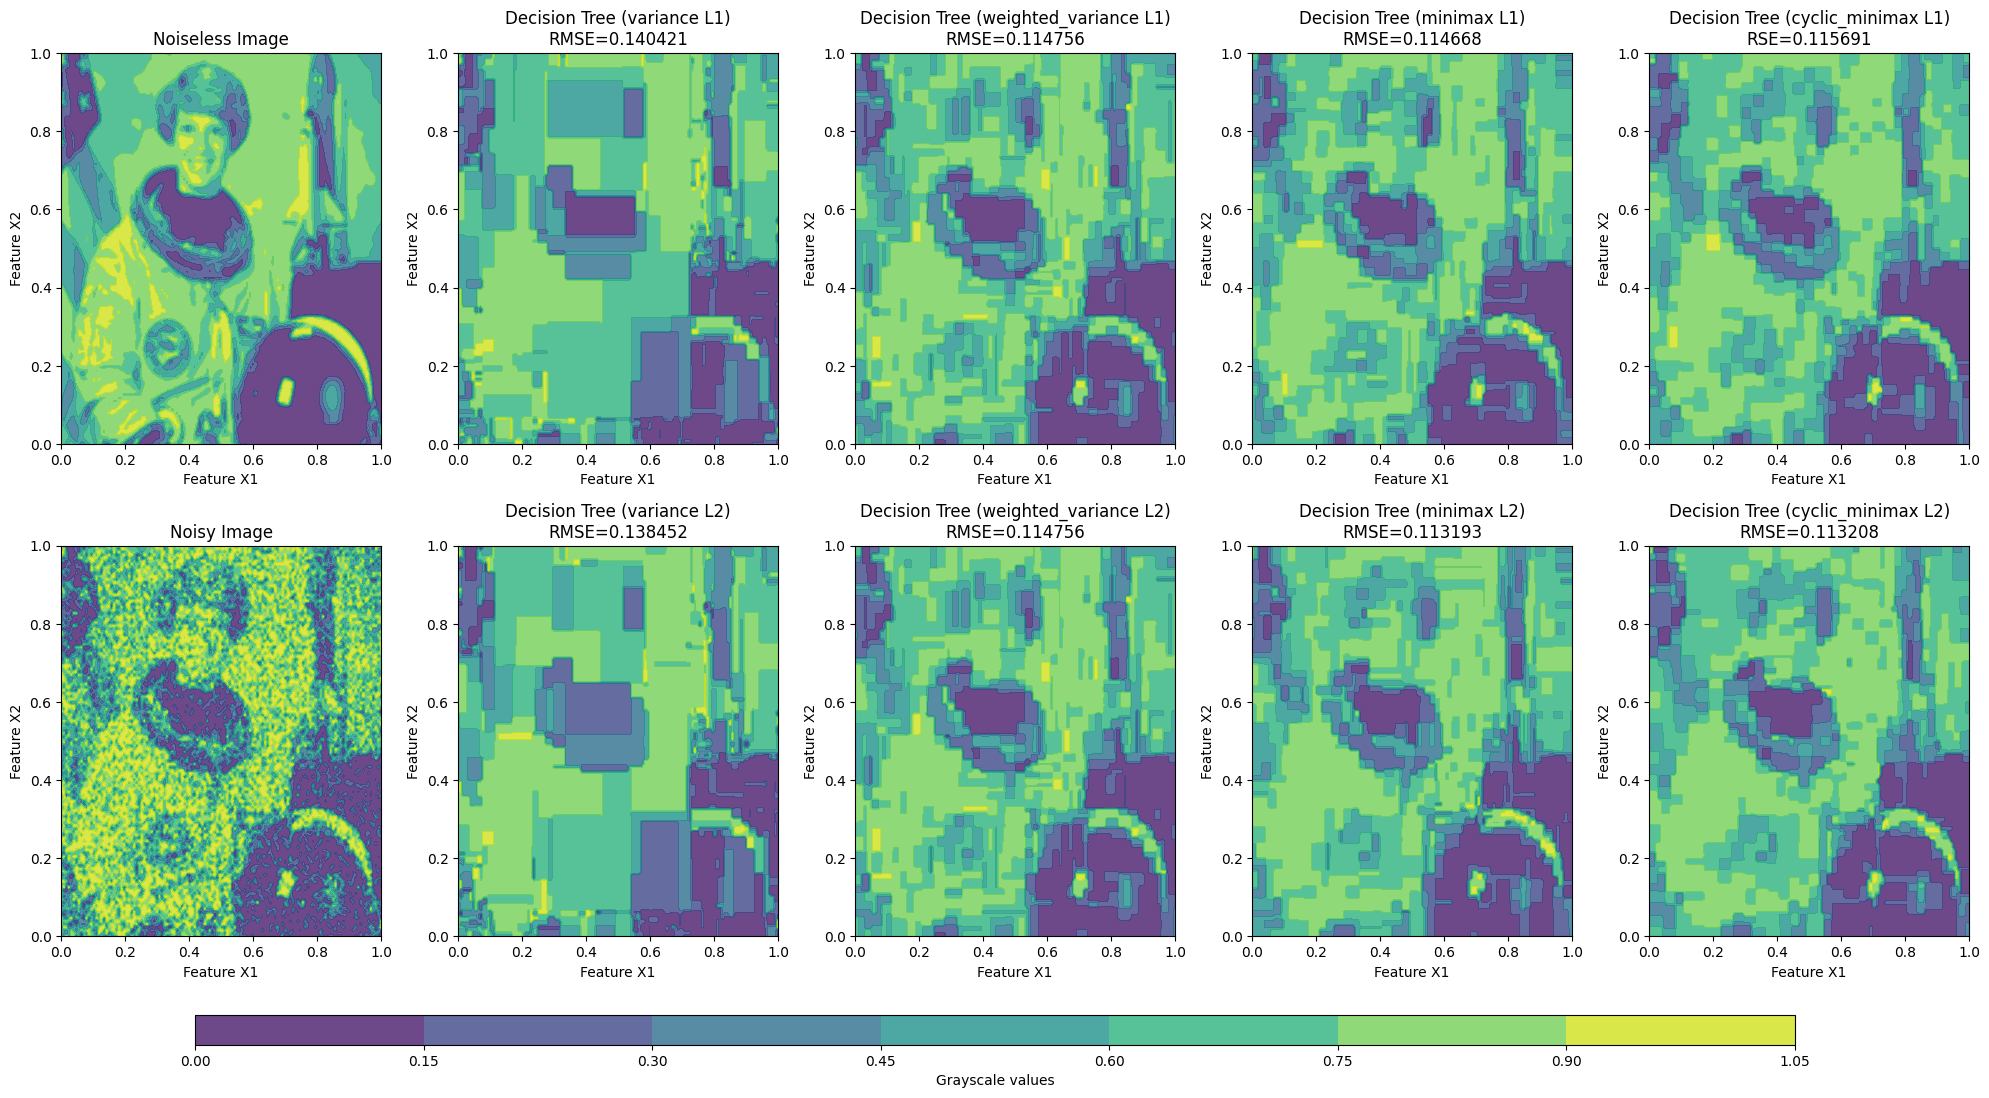

[0.019718052657363382]
[0.013148845709271918]


In [3]:
# Plotting the original data and the decision tree approximation
# Create the figure and axes
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

# List of data and titles
data = [y_new.reshape(X1.shape), predictions1, predictions1b, predictions2, predictions2b, y.reshape(X1.shape), predictions3, predictions3b, predictions4, predictions4b,predictions4c,predictions4d]
titles = ['Noiseless Image',
        'Decision Tree (variance L1)\nRMSE=' + str(np.round(np.mean((predictions1.ravel()-y_new)**2)**0.5, 6)),
        'Decision Tree (weighted_variance L1)\nRMSE=' + str(np.round(np.mean((predictions1b.ravel()-y_new)**2)**0.5, 6)),
        'Decision Tree (minimax L1)\nRMSE=' + str(np.round(np.mean((predictions2.ravel()-y_new)**2)**0.5, 6)),
        'Decision Tree (cyclic_minimax L1)\nRSE=' + str(np.round(np.mean((predictions2b.ravel()-y_new)**2)**0.5, 6)),
        #'Decision Tree (xminimizer L1)\nMSE=' + str(np.round(np.mean((predictions2c.ravel()-y_new)**2), 6)),
        'Noisy Image',
        'Decision Tree (variance L2)\nRMSE=' + str(np.round(np.mean((predictions3.ravel()-y_new)**2)**0.5, 6)),
        'Decision Tree (weighted_variance L2)\nRMSE=' + str(np.round(np.mean((predictions3b.ravel()-y_new)**2)**0.5, 6)),
        'Decision Tree (minimax L2)\nRMSE=' + str(np.round(np.mean((predictions4.ravel()-y_new)**2)**0.5, 6)),
        'Decision Tree (cyclic_minimax L2)\nRMSE=' + str(np.round(np.mean((predictions4b.ravel()-y_new)**2)**0.5, 6)),
        #'Decision Tree (xminimizer L2)\nMSE=' + str(np.round(np.mean((predictions4c.ravel()-y_new)**2), 6))
        ]

# Plot each subplot
axes_flat = axes.flatten()
for i, ax in enumerate(axes_flat):
    im = ax.contourf(X1, X2, data[i], cmap='viridis', alpha=0.8)
    ax.set_title(titles[i])
    ax.set_xlabel('Feature X1')
    ax.set_ylabel('Feature X2')

# Adjust the layout to make room for the colorbar
plt.tight_layout()
fig.subplots_adjust(bottom=0.2)

# Add a colorbar at the bottom
cbar_ax = fig.add_axes([0.1, -0.05, 0.8, 0.03])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Grayscale values')

plt.tight_layout()
plt.show()

#these are logarithms of the MSE
print(vari1)
print(mini1)

#plt.plot(np.log(vari1), np.log(mini1),np.log(vari2), np.log(mini2))
#plt.legend()
#plt.show()

#import time
#from IPython.display import display, Javascript

#def keep_alive():
#    display(Javascript('function connect(){ console.log("Connecting to prevent timeout"); } setInterval(connect, 60000);'))

#keep_alive()

In [4]:
#tree4.print_tree()
# List initialization
list_starting_with_variance = []
list_starting_with_minimax = []

# Length of the lists
length_of_lists = MY_DEPTH

# Fill the lists
for i in range(length_of_lists):
    if i % 2 == 0:  # Even index
        list_starting_with_variance.append('weighted_variance')
        list_starting_with_minimax.append('xminimizer')
    else:  # Odd index
        list_starting_with_variance.append('minimax')
        list_starting_with_minimax.append('weighted_variance')

# Output the lists
print("List starting with 'variance':", list_starting_with_variance)
print("List starting with 'minimax':", list_starting_with_minimax)

# Create lists by concatenating 'minimax' and 'variance' in different orders
list_minimax_then_variance = ['minimax'] * (length_of_lists//2) + ['weighted_variance'] * (length_of_lists//2)
list_variance_then_minimax = ['weighted_variance'] * (length_of_lists//2) + ['minimax'] * (length_of_lists//2)

# Output the lists
print("List with 5 'minimax' followed by 5 'variance':", list_minimax_then_variance)
print("List with 5 'variance' followed by 5 'minimax':", list_variance_then_minimax)


List starting with 'variance': ['weighted_variance', 'minimax', 'weighted_variance', 'minimax', 'weighted_variance', 'minimax', 'weighted_variance', 'minimax', 'weighted_variance', 'minimax']
List starting with 'minimax': ['xminimizer', 'weighted_variance', 'xminimizer', 'weighted_variance', 'xminimizer', 'weighted_variance', 'xminimizer', 'weighted_variance', 'xminimizer', 'weighted_variance']
List with 5 'minimax' followed by 5 'variance': ['minimax', 'minimax', 'minimax', 'minimax', 'minimax', 'weighted_variance', 'weighted_variance', 'weighted_variance', 'weighted_variance', 'weighted_variance']
List with 5 'variance' followed by 5 'minimax': ['weighted_variance', 'weighted_variance', 'weighted_variance', 'weighted_variance', 'weighted_variance', 'minimax', 'minimax', 'minimax', 'minimax', 'minimax']


10


/tmp/ipykernel_2569631/2848107388.py:66: RuntimeWarning: Mean of empty slice.
  node = self.Node(value=y.mean(), data=X, targets=y)
/tmp/ipykernel_2569631/2581161022.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


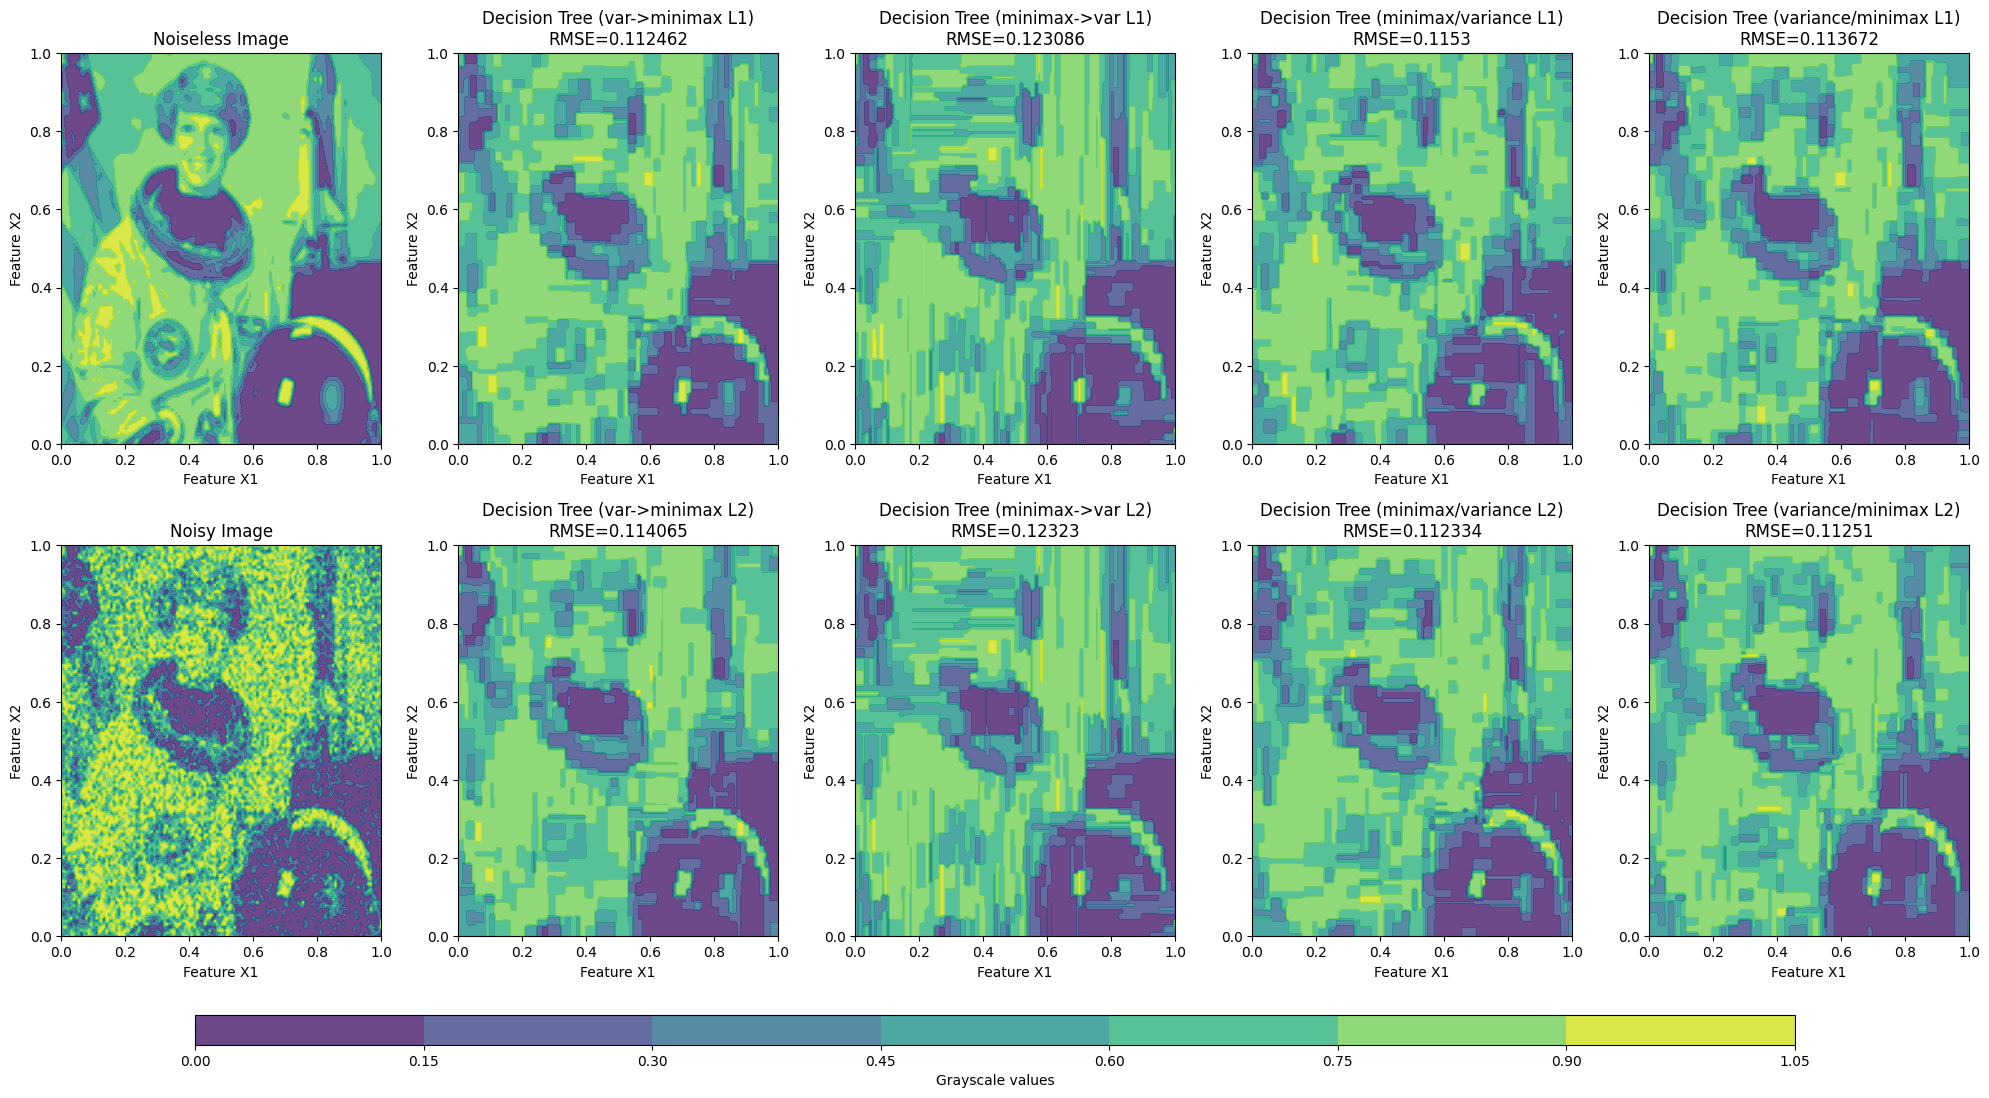

[0.012647650351521319]
[0.013293987426077207]


In [5]:
y = noisy_image.flatten(order='F')

vari1=[]
wvari1=[]
mini1=[]
cyclic1=[]
vari2=[]
wvari2=[]
mini2=[]
cyclic2=[]

logvari=[]
logmini=[]
for depth in [MY_DEPTH]:
    print(depth)
    # Prepare the mesh grid for predictions and visualization
    X_new = np.c_[X1.ravel(), X2.ravel()]
    y_new = original_image.flatten(order='F')  # Slightly less noise for cleaner function visualization
    # Assuming the DecisionTreeRegressor class has already been imported and is available
    tree1 = DecisionTreeRegressor(min_samples_split=2, max_depth=depth, error_method=list_starting_with_variance,loss_norm=1)
    tree1.root = tree1.fit(X, y)
    # Make predictions on the grid
    predictions1 = tree1.predict(X_new)
    predictions1 = np.asarray(predictions1).reshape(X1.shape)  # Reshape to 2D grid
    logvari.append(np.log(np.mean((predictions1.ravel()-y_new)**2)))
    vari1.append(np.mean((predictions1.ravel()-y_new)**2))

    tree1b = DecisionTreeRegressor(min_samples_split=2, max_depth=depth, error_method=list_starting_with_minimax,loss_norm=1)
    tree1b.root = tree1b.fit(X, y)
    # Make predictions on the grid
    predictions1b = tree1b.predict(X_new)
    predictions1b = np.asarray(predictions1b).reshape(X1.shape)  # Reshape to 2D grid
    wvari1.append(np.mean((predictions1b.ravel()-y_new)**2))

    tree2 = DecisionTreeRegressor(min_samples_split=2, max_depth=depth, error_method=list_minimax_then_variance,loss_norm=1)
    tree2.root = tree2.fit(X, y)
    # Make predictions on the grid
    predictions2 = tree2.predict(X_new)
    predictions2 = np.asarray(predictions2).reshape(X1.shape)  # Reshape to 2D grid
    mini1.append(np.mean((predictions2.ravel()-y_new)**2))

    tree2b = DecisionTreeRegressor(min_samples_split=2, max_depth=depth, error_method=list_variance_then_minimax,loss_norm=1)
    tree2b.root = tree2b.fit(X, y)
    # Make predictions on the grid
    predictions2b = tree2b.predict(X_new)
    predictions2b = np.asarray(predictions2b).reshape(X1.shape)  # Reshape to 2D grid
    cyclic1.append(np.mean((predictions2b.ravel()-y_new)**2))


    tree3 = DecisionTreeRegressor(min_samples_split=2, max_depth=depth, error_method=list_starting_with_variance,loss_norm=2)
    tree3.root = tree3.fit(X, y)
    # Make predictions on the grid
    predictions3 = tree3.predict(X_new)
    predictions3 = np.asarray(predictions3).reshape(X1.shape)  # Reshape to 2D grid
    vari2.append(np.mean((predictions3.ravel()-y_new)**2))

    tree3b = DecisionTreeRegressor(min_samples_split=2, max_depth=depth, error_method=list_starting_with_minimax,loss_norm=2)
    tree3b.root = tree3b.fit(X, y)
    # Make predictions on the grid
    predictions3b = tree3b.predict(X_new)
    predictions3b = np.asarray(predictions3b).reshape(X1.shape)  # Reshape to 2D grid
    wvari2.append(np.mean((predictions3b.ravel()-y_new)**2))

    tree4 = DecisionTreeRegressor(min_samples_split=2, max_depth=depth, error_method=list_minimax_then_variance,loss_norm=2)
    tree4.root = tree4.fit(X, y)
    # Make predictions on the grid
    predictions4 = tree4.predict(X_new)
    predictions4 = np.asarray(predictions4).reshape(X1.shape)  # Reshape to 2D grid
    mini2.append(np.mean((predictions4.ravel()-y_new)**2))

    tree4b = DecisionTreeRegressor(min_samples_split=2, max_depth=depth, error_method=list_variance_then_minimax,loss_norm=2)
    tree4b.root = tree4b.fit(X, y)
    # Make predictions on the grid
    predictions4b = tree4b.predict(X_new)
    predictions4b = np.asarray(predictions4b).reshape(X1.shape)  # Reshape to 2D grid
    cyclic2.append(np.mean((predictions4b.ravel()-y_new)**2))

    # Plotting the original data and the decision tree approximation
    # Create the figure and axes
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))

    # List of data and titles
    data = [y_new.reshape(X1.shape), predictions1, predictions1b, predictions2, predictions2b, y.reshape(X1.shape), predictions3, predictions3b, predictions4, predictions4b]
    titles = ['Noiseless Image',
            'Decision Tree (var->minimax L1)\nRMSE=' + str(np.round(np.mean((predictions1.ravel()-y_new)**2)**0.5, 6)),
            'Decision Tree (minimax->var L1)\nRMSE=' + str(np.round(np.mean((predictions1b.ravel()-y_new)**2)**0.5, 6)),
            'Decision Tree (minimax/variance L1)\nRMSE=' + str(np.round(np.mean((predictions2.ravel()-y_new)**2)**0.5, 6)),
            'Decision Tree (variance/minimax L1)\nRMSE=' + str(np.round(np.mean((predictions2b.ravel()-y_new)**2)**0.5, 6)),
            'Noisy Image',
            'Decision Tree (var->minimax L2)\nRMSE=' + str(np.round(np.mean((predictions3.ravel()-y_new)**2)**0.5, 6)),
            'Decision Tree (minimax->var L2)\nRMSE=' + str(np.round(np.mean((predictions3b.ravel()-y_new)**2)**0.5, 6)),
            'Decision Tree (minimax/variance L2)\nRMSE=' + str(np.round(np.mean((predictions4.ravel()-y_new)**2)**0.5, 6)),
            'Decision Tree (variance/minimax L2)\nRMSE=' + str(np.round(np.mean((predictions4b.ravel()-y_new)**2)**0.5, 6))]

    # Plot each subplot
    axes_flat = axes.flatten()
    for i, ax in enumerate(axes_flat):
        im = ax.contourf(X1, X2, data[i], cmap='viridis', alpha=0.8)
        ax.set_title(titles[i])
        ax.set_xlabel('Feature X1')
        ax.set_ylabel('Feature X2')

    # Adjust the layout to make room for the colorbar
    plt.tight_layout()
    fig.subplots_adjust(bottom=0.2)

    # Add a colorbar at the bottom
    cbar_ax = fig.add_axes([0.1, -0.05, 0.8, 0.03])
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('Grayscale values')

    plt.tight_layout()
    plt.show()

#these are logarithms of the MSE
print(vari1)
print(mini1)

#plt.plot(np.log(vari1), np.log(mini1),np.log(vari2), np.log(mini2))
#plt.legend()
#plt.show()

#import time
#from IPython.display import display, Javascript

#def keep_alive():
#    display(Javascript('function connect(){ console.log("Connecting to prevent timeout"); } setInterval(connect, 60000);'))

#keep_alive()

10


/tmp/ipykernel_2569631/2848107388.py:66: RuntimeWarning: Mean of empty slice.
  node = self.Node(value=y.mean(), data=X, targets=y)
/tmp/ipykernel_2569631/2457716829.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


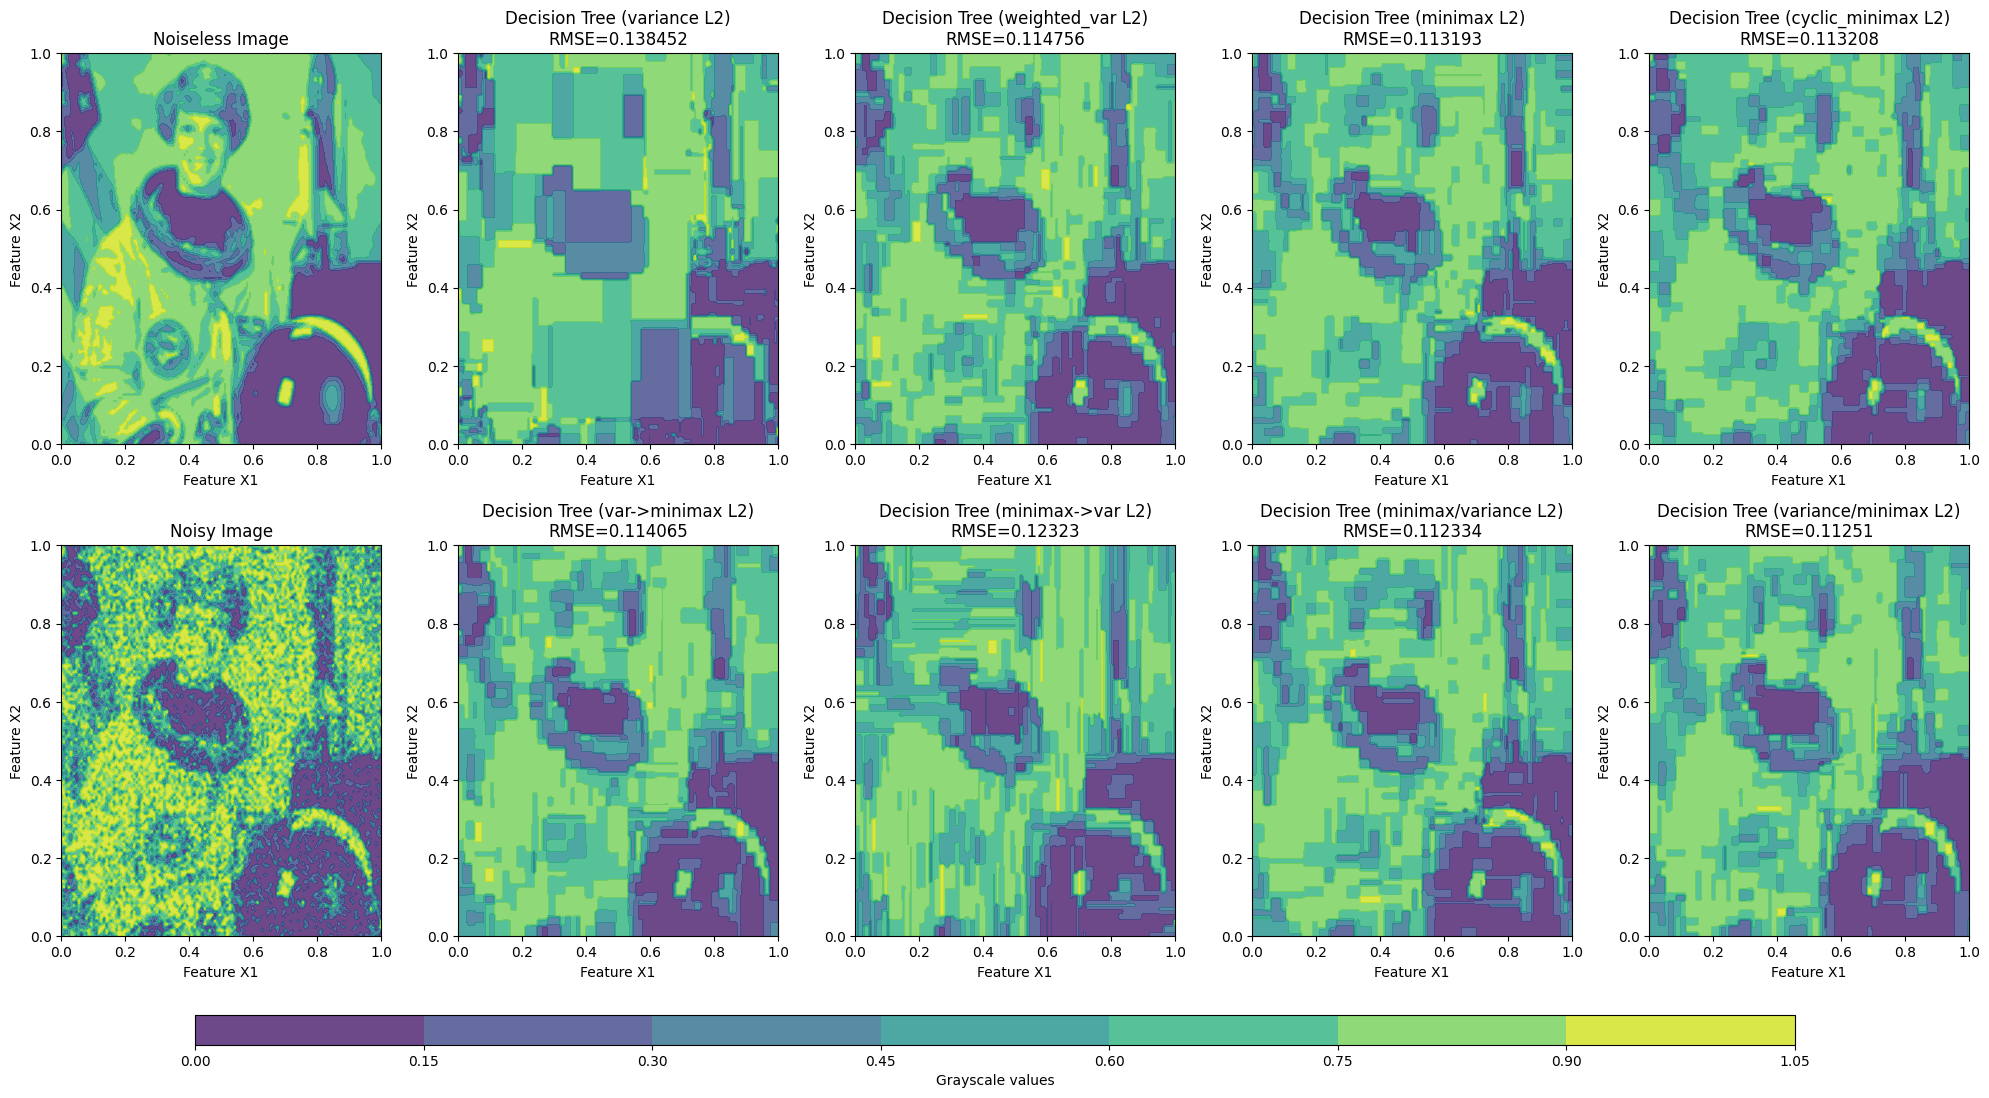

[0.019169057569298632]
[0.012812603876244088]


In [6]:
y = noisy_image.flatten(order='F')

vari1=[]
wvari1=[]
mini1=[]
cyclic1=[]
vari2=[]
wvari2=[]
mini2=[]
cyclic2=[]

logvari=[]
logmini=[]
for depth in [MY_DEPTH]:
    print(depth)
    # Prepare the mesh grid for predictions and visualization
    X_new = np.c_[X1.ravel(), X2.ravel()]
    y_new = original_image.flatten(order='F')  # Slightly less noise for cleaner function visualization
    # Assuming the DecisionTreeRegressor class has already been imported and is available
    tree1 = DecisionTreeRegressor(min_samples_split=2, max_depth=depth, error_method='variance',loss_norm=2)
    tree1.root = tree1.fit(X, y)
    # Make predictions on the grid
    predictions1 = tree1.predict(X_new)
    predictions1 = np.asarray(predictions1).reshape(X1.shape)  # Reshape to 2D grid
    logvari.append(np.log(np.mean((predictions1.ravel()-y_new)**2)))
    vari1.append(np.mean((predictions1.ravel()-y_new)**2))

    tree1b = DecisionTreeRegressor(min_samples_split=2, max_depth=depth, error_method='weighted_variance',loss_norm=2)
    tree1b.root = tree1b.fit(X, y)
    # Make predictions on the grid
    predictions1b = tree1b.predict(X_new)
    predictions1b = np.asarray(predictions1b).reshape(X1.shape)  # Reshape to 2D grid
    wvari1.append(np.mean((predictions1b.ravel()-y_new)**2))

    tree2 = DecisionTreeRegressor(min_samples_split=2, max_depth=depth, error_method='minimax',loss_norm=2)
    tree2.root = tree2.fit(X, y)
    # Make predictions on the grid
    predictions2 = tree2.predict(X_new)
    predictions2 = np.asarray(predictions2).reshape(X1.shape)  # Reshape to 2D grid
    mini1.append(np.mean((predictions2.ravel()-y_new)**2))

    tree2b = DecisionTreeRegressor(min_samples_split=2, max_depth=depth, error_method='cyclic_minimax',loss_norm=2)
    tree2b.root = tree2b.fit(X, y)
    # Make predictions on the grid
    predictions2b = tree2b.predict(X_new)
    predictions2b = np.asarray(predictions2b).reshape(X1.shape)  # Reshape to 2D grid
    cyclic1.append(np.mean((predictions2b.ravel()-y_new)**2))


    tree3 = DecisionTreeRegressor(min_samples_split=2, max_depth=depth, error_method=list_starting_with_variance,loss_norm=2)
    tree3.root = tree3.fit(X, y)
    # Make predictions on the grid
    predictions3 = tree3.predict(X_new)
    predictions3 = np.asarray(predictions3).reshape(X1.shape)  # Reshape to 2D grid
    vari2.append(np.mean((predictions3.ravel()-y_new)**2))

    tree3b = DecisionTreeRegressor(min_samples_split=2, max_depth=depth, error_method=list_starting_with_minimax,loss_norm=2)
    tree3b.root = tree3b.fit(X, y)
    # Make predictions on the grid
    predictions3b = tree3b.predict(X_new)
    predictions3b = np.asarray(predictions3b).reshape(X1.shape)  # Reshape to 2D grid
    wvari2.append(np.mean((predictions3b.ravel()-y_new)**2))

    tree4 = DecisionTreeRegressor(min_samples_split=2, max_depth=depth, error_method=list_minimax_then_variance,loss_norm=2)
    tree4.root = tree4.fit(X, y)
    # Make predictions on the grid
    predictions4 = tree4.predict(X_new)
    predictions4 = np.asarray(predictions4).reshape(X1.shape)  # Reshape to 2D grid
    mini2.append(np.mean((predictions4.ravel()-y_new)**2))

    tree4b = DecisionTreeRegressor(min_samples_split=2, max_depth=depth, error_method=list_variance_then_minimax,loss_norm=2)
    tree4b.root = tree4b.fit(X, y)
    # Make predictions on the grid
    predictions4b = tree4b.predict(X_new)
    predictions4b = np.asarray(predictions4b).reshape(X1.shape)  # Reshape to 2D grid
    cyclic2.append(np.mean((predictions4b.ravel()-y_new)**2))

    # Plotting the original data and the decision tree approximation
    # Create the figure and axes
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))

    # List of data and titles
    data = [y_new.reshape(X1.shape), predictions1, predictions1b, predictions2, predictions2b, y.reshape(X1.shape), predictions3, predictions3b, predictions4, predictions4b]
    titles = ['Noiseless Image',
            'Decision Tree (variance L2)\nRMSE=' + str(np.round(np.mean((predictions1.ravel()-y_new)**2)**0.5, 6)),
            'Decision Tree (weighted_var L2)\nRMSE=' + str(np.round(np.mean((predictions1b.ravel()-y_new)**2)**0.5, 6)),
            'Decision Tree (minimax L2)\nRMSE=' + str(np.round(np.mean((predictions2.ravel()-y_new)**2)**0.5, 6)),
            'Decision Tree (cyclic_minimax L2)\nRMSE=' + str(np.round(np.mean((predictions2b.ravel()-y_new)**2)**0.5, 6)),
            'Noisy Image',
            'Decision Tree (var->minimax L2)\nRMSE=' + str(np.round(np.mean((predictions3.ravel()-y_new)**2)**0.5, 6)),
            'Decision Tree (minimax->var L2)\nRMSE=' + str(np.round(np.mean((predictions3b.ravel()-y_new)**2)**0.5, 6)),
            'Decision Tree (minimax/variance L2)\nRMSE=' + str(np.round(np.mean((predictions4.ravel()-y_new)**2)**0.5, 6)),
            'Decision Tree (variance/minimax L2)\nRMSE=' + str(np.round(np.mean((predictions4b.ravel()-y_new)**2)**0.5, 6))]

    # Plot each subplot
    axes_flat = axes.flatten()
    for i, ax in enumerate(axes_flat):
        im = ax.contourf(X1, X2, data[i], cmap='viridis', alpha=0.8)
        ax.set_title(titles[i])
        ax.set_xlabel('Feature X1')
        ax.set_ylabel('Feature X2')

    # Adjust the layout to make room for the colorbar
    plt.tight_layout()
    fig.subplots_adjust(bottom=0.2)

    # Add a colorbar at the bottom
    cbar_ax = fig.add_axes([0.1, -0.05, 0.8, 0.03])
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('Grayscale values')

    plt.tight_layout()
    plt.show()

#these are logarithms of the MSE
print(vari1)
print(mini1)

#plt.plot(np.log(vari1), np.log(mini1),np.log(vari2), np.log(mini2))
#plt.legend()
#plt.show()

#import time
#from IPython.display import display, Javascript

#def keep_alive():
#    display(Javascript('function connect(){ console.log("Connecting to prevent timeout"); } setInterval(connect, 60000);'))

#keep_alive()